---
# Trip Duration Prediction

**Author:** Jan Xu

**Date:** 05/05/2019

___

## Import modules

In [236]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import datetime
import random
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, BatchNormalization
from keras.regularizers import l2
from xgboost import XGBRegressor

import gmplot
import googlemaps

# Step 0: Import data

In [183]:
train_df = pd.read_csv("dataset/train.csv", index_col="row_id")
test_df = pd.read_csv("dataset/test.csv", index_col="row_id")
combine = [train_df, test_df]

train_df.head()

,start_lng,start_lat,end_lng,end_lat,datetime,duration
row_id,,,,,,
0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0
3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0
4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0


In [184]:
# Visualize training data points
gmap = gmplot.GoogleMapPlotter(train_df.start_lat.mean(), train_df.start_lng.mean(), 4)
gmap.heatmap(train_df.start_lat, train_df.start_lng)

# Store html with geospatial Google Maps heatmap
gmap.draw("gmaps/heatmap.html")

![ce263n](img/data_points.png)

Looks like the main data points are in San Francisco and in New York.

# Step 1: Exploratory Data Analysis

In [185]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146001 entries, 0 to 146000
Data columns (total 6 columns):
start_lng    145601 non-null float64
start_lat    146001 non-null float64
end_lng      146001 non-null float64
end_lat      145401 non-null float64
datetime     146001 non-null object
duration     146001 non-null float64
dtypes: float64(5), object(1)
memory usage: 7.8+ MB


In [186]:
train_df.describe()

,start_lng,start_lat,end_lng,end_lat,duration
count,145601.000000,146001.000000,146001.000000,145401.000000,146001.000000
mean,-86.465695,39.913703,-87.177163,39.922772,1063.222314
std,25.468467,1.339508,22.225753,1.336437,3305.905829
min,-122.515832,37.459648,-122.634420,37.225640,0.000000
25%,-122.393532,37.798430,-122.392458,37.800318,382.000000
50%,-73.989830,40.741089,-73.988754,40.740990,631.000000
75%,-73.974190,40.762104,-73.971245,40.762669,1020.000000
max,74.100212,40.994354,-50.336068,41.005390,42168.000000


In [187]:
# Convert to datetime and drop NA's
for df in combine:
    df.datetime = pd.to_datetime(df.datetime)
    df.dropna(axis=0, inplace=True)

In [188]:
# Drop invalid routes
train_df.drop([90810, 81553, 83473, 87892, 96380], axis=0, inplace=True)

# Drop trips above 20000 seconds
train_df.drop(train_df[train_df.duration > 7200.0].index, axis=0, inplace=True)

# Drop zero durations
train_df.drop(train_df.loc[(train_df.duration == 0) &
                           ((train_df.start_lng != train_df.end_lng) |
                            (train_df.start_lat != train_df.end_lat))].index, axis=0, inplace=True)

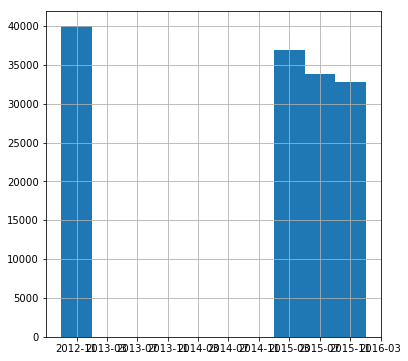

In [189]:
# Check datetime values
train_df.datetime.hist(figsize=(6,6))
plt.show()

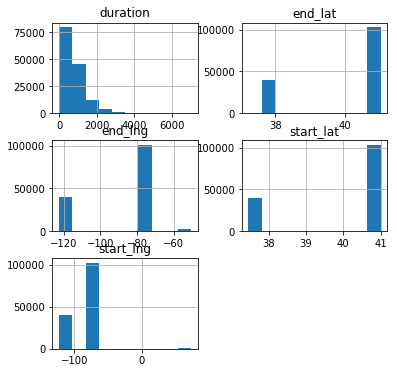

In [190]:
# Check all other features
train_df.hist(figsize=(6,6))
plt.show()

In [191]:
# Check coordinate anomalies in start_lng
mismatched = train_df[train_df.start_lng > 50]
gmap = gmplot.GoogleMapPlotter(mismatched.start_lat.iloc[0], mismatched.start_lng.iloc[0], 7)
gmap.heatmap(mismatched.start_lat, mismatched.start_lng)
gmap.draw("gmaps/mismatched.html")

![ce263n](img/kyrgyzstan.png)

Whoops! Looks like a few data points are mismatched. The "start_lng" seem to be positive instead of negative. We should fix this.

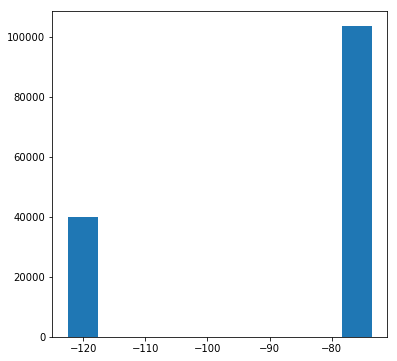

In [192]:
train_df.loc[mismatched.index, "start_lng"] = -train_df.loc[mismatched.index].start_lng
plt.figure(figsize=(6,6))
plt.hist(train_df.start_lng)
plt.show()

Much better! Now, let's check the coordinate anomalies in end_lng.

In [193]:
# Check coordinate anomalies in end_lng
mismatched2 = train_df[train_df.end_lng > -60]
gmap = gmplot.GoogleMapPlotter(mismatched2.end_lat.iloc[0], mismatched2.end_lng.iloc[0], 5)
gmap.heatmap(mismatched2.end_lat, mismatched2.end_lng)
gmap.draw("gmaps/mismatched2.html")

![ce263n](img/northatlantic.png)

We are swimming in deep waters here. We should remove these data points.

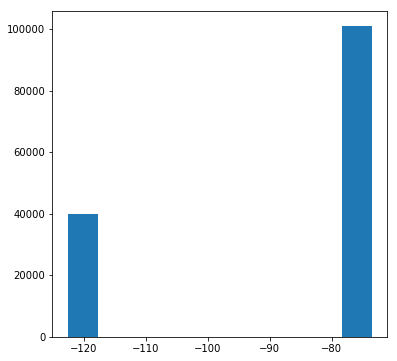

In [194]:
train_df.drop(mismatched2.index, axis=0, inplace=True)
plt.figure(figsize=(6,6))
plt.hist(train_df.end_lng)
plt.show()

Looks nice!

In [195]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140965 entries, 0 to 146000
Data columns (total 6 columns):
start_lng    140965 non-null float64
start_lat    140965 non-null float64
end_lng      140965 non-null float64
end_lat      140965 non-null float64
datetime     140965 non-null datetime64[ns]
duration     140965 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 7.5 MB


# Step 2: Feature Engineering

## Estimate distances

In [196]:
# Manhattan and Euclidean (Havesine) distances
def distance(df, method="manhattan"):
    earthR = 6378137.0
    pi180 = np.pi/180
    
    dlat = (df.end_lat - df.start_lat) * pi180
    dlng = (df.end_lng - df.start_lng) * pi180
    
    if method == "manhattan":
        ay = np.sin(np.abs(dlat)/2)**2
        cy = 2*np.arctan2(np.sqrt(ay), np.sqrt(1-ay))
        dy = earthR * cy

        ax = np.sin(np.abs(dlng)/2)**2
        cx = 2*np.arctan2(np.sqrt(ax), np.sqrt(1-ax))
        dx = earthR * cx

        distance = np.abs(dx) + np.abs(dy)
    
    elif method == "euclidean":
        a = (np.sin(dlat/2)**2 + np.cos(df.start_lat*pi180) * np.cos(df.end_lat*pi180) * np.sin(dlng/2)**2)
        c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
        
        distance = earthR * c
    else:
        distance = 0
        
    return distance

In [197]:
for df in combine:
    df["manhattan"] = distance(df, method="manhattan")
    df["euclidean"] = distance(df, method="euclidean")

### Extract Google Maps data

The gmaps data was pre-downloaded by running the function ```extract_gmaps_data``` on both the training and test data. This was then imported later for usage in the model.

In [198]:
# Not used here
def extract_gmaps_data(df, test=False):
    gmaps = googlemaps.Client("<API-KEY>")
    
    distances = []
    durations = []
    
    df['pickup'] = df.start_lat.astype(str)+","+df.start_lng.astype(str)
    df['dropoff'] = df.end_lat.astype(str)+","+df.end_lng.astype(str)
    
    firstindex = df.index[0]
    finalindex = df.index[-1]
    interval = finalindex - firstindex
    
    for i in tqdm(range(interval // 9 + 1)):
        lastindex = firstindex + 8
        df_9 = df.loc[firstindex:lastindex]

        result = gmaps.distance_matrix(df_9.pickup.values,
                                       df_9.dropoff.values,
                                       units="metric")

        for i in range(len(df_9)):
            try:
                distances.append(result["rows"][i]["elements"][i]["distance"]["value"])
                durations.append(result["rows"][i]["elements"][i]["duration"]["value"])
            except:
                distances.append(0)
                durations.append(0)

        firstindex = lastindex + 1

    df['gmaps_dist'] = np.array(distances)
    df['gmaps_duration'] = np.array(durations)
    
    if test:
        save_gmaps_test_data(df)
    else:
        save_gmaps_train_data(df)
    
    return df

def save_gmaps_train_data(df):
    df[["gmaps_dist", "gmaps_duration"]].to_csv("gmapsdata/{0}-{1}.csv".format(df.index[0], df.index[-1]))
    
def save_gmaps_test_data(df):
    df[["gmaps_dist", "gmaps_duration"]].to_csv("gmapsdata/{0}-{1}.csv".format(df.index[0], df.index[-1]))

In [199]:
# Not used, data already extracted

"""
start = 0
interval = 10000

while start < len(train_df):
    print("Now starting with batch of the {0}'s...".format(start))
    train = train_df.loc[start:start+interval-1]
    train = extract_gmaps_data(train, test=False)
    start += interval

start = 0

while start < len(test_df):
    print("Now starting with batch of the {0}'s...".format(start))
    test = test_df.loc[start:start+interval-1]
    test = extract_gmaps_data(test, test=True)
    start += interval
"""
None

In [200]:
# Import gmaps data
gmaps_train_data = pd.read_csv("gmapsdata/gmaps_train_data.csv", index_col="row_id")
gmaps_test_data = pd.read_csv("gmapsdata/gmaps_test_data.csv", index_col="row_id")
    
train_df["gmaps_dist"] = gmaps_train_data.gmaps_dist
train_df["gmaps_duration"] = gmaps_train_data.gmaps_duration
train_df.dropna(axis=0, inplace=True)
    
test_df["gmaps_dist"] = gmaps_test_data.gmaps_dist
test_df["gmaps_duration"] = gmaps_test_data.gmaps_duration
test_df.dropna(axis=0, inplace=True)

In [201]:
# Treasure Island fix
for df in combine:
    TI_df = df[df.gmaps_dist == 0].loc[df.manhattan > 2000]
    df.loc[TI_df.index, "gmaps_dist"] = TI_df.manhattan
    df.loc[TI_df.index, "gmaps_duration"] = TI_df.manhattan / 11.0

## Time features

In [202]:
# Add weekdays, hour and date columns and drop datetime
for df in combine:
    df["weekday"] = df.datetime.dt.weekday + 1
    df["hour"] = df.datetime.dt.hour
    df["date"] = df.datetime.dt.date
    df.drop("datetime", axis=1, inplace=True)

In [203]:
# Add marker for holidays (only 2015 since 2012 data is only one month)
holidays2015 = {
    "New Years Day": datetime.datetime(2015,1,1).date(),
    "Martin Luther King Day": datetime.datetime(2015,1,19).date(),
    "Easter Saturday": datetime.datetime(2015,4,4).date(),
    "Easter Sunday": datetime.datetime(2015,4,5).date(),
    "Memorial Sunday": datetime.datetime(2015,5,24).date(),
    "Memorial Day": datetime.datetime(2015,5,25).date(),
    "Independence Pre-day": datetime.datetime(2015,7,3).date(),
    "Independence Day": datetime.datetime(2015,7,4).date(),
    "Independence Post-day": datetime.datetime(2015,7,5).date(),
    "Labor Day": datetime.datetime(2015,9,7).date(),
    "Thanksgiving Day": datetime.datetime(2015,11,26).date(),
    "Thanksgiving Post-day": datetime.datetime(2015,11,27).date(),
    "Thanksgiving Post-post-day": datetime.datetime(2015,11,28).date(),
    "Christmas Eve": datetime.datetime(2015,12,24).date(),
    "Christmas Day": datetime.datetime(2015,12,25).date(),
    "Christmas Post-day": datetime.datetime(2015,12,26).date(),
    "New Years Eve": datetime.datetime(2015,12,31).date(),
}

for df in combine:
    df["holiday"] = np.zeros(df.index.shape)

    for d in holidays2015.values():
        df.loc[df.date == d, ['holiday']] = 1

## Geolocations

In [204]:
# Clustering hotspots
def geolocations(combine):
    train_df = combine[0]
    test_df = combine[1]
    
    # Collate coordinates
    train_df['train_or_test'] = "train"
    test_df['train_or_test'] = "test"
    train_test = pd.concat([train_df,test_df]).reset_index()

    start = pd.DataFrame(train_test[["row_id", "start_lat", "start_lng", "train_or_test"]].values, columns=["row_id", "lat", "lng", "train_or_test"])
    start['start_or_end'] = "start"
    end = pd.DataFrame(train_test[["row_id", "end_lat", "end_lng", "train_or_test"]].values, columns=["row_id", "lat", "lng", "train_or_test"])
    end['start_or_end'] = "end"
    coords = pd.concat([start,end]).reset_index(drop=True)

    # Find clusters
    DB = DBSCAN(eps=0.005, min_samples=2500).fit(coords[["lng", "lat"]])
    print("Number of clusters found:", max(DB.labels_) + 1)
    
    # Visualize clusters
    for i in range(max(DB.labels_) + 1):
        cluster = coords.loc[np.argwhere(DB.labels_ == i).flatten()]
        gmap = gmplot.GoogleMapPlotter(cluster.lat.sample(1).values[0], cluster.lng.sample(1).values[0], 12)
        gmap.heatmap(cluster.lat, cluster.lng)
        gmap.draw("gmaps/cluster{0}.html".format(i))
    
    # As seen, the following clusters are:
    # -1 -> not clustered (standalone)
    # 0  -> SF Market Street (city)
    # 1  -> NY Manhattan (city)
    # 2  -> SFO Airport (airport)
    # 3  -> North SF (city)
    # 4  -> SF Mission District (city)
    # 5  -> JFK Airport (airport)
    # 6  -> LaGuardia Airport (airport)
    
    # Label clusters
    clusters = []
    for i in DB.labels_:
        if i == -1:
            clusters.append("standalone")
        elif i in [0, 1, 3, 4]:
            clusters.append("city")
        elif i in [2, 5, 6]:
            clusters.append("airport")
    
    # Visualize distribution of trips per cluster
    location = np.array(clusters)
    pd.value_counts(location).plot.bar()
    plt.show()
    
    # Add flags to columns
    coords['location'] = location

    train_locs = coords.loc[coords.train_or_test == "train"]
    test_locs = coords.loc[coords.train_or_test == "test"]

    train_start_locs = train_locs.loc[train_locs.start_or_end == "start"].loc[:,["row_id","location"]].set_index("row_id")
    train_end_locs = train_locs.loc[train_locs.start_or_end == "end"].loc[:,["row_id","location"]].set_index("row_id")
    test_start_locs = test_locs.loc[test_locs.start_or_end == "start"].loc[:,["row_id","location"]].set_index("row_id")
    test_end_locs = test_locs.loc[test_locs.start_or_end == "end"].loc[:,["row_id","location"]].set_index("row_id")

    train_df["start_loc"] = train_start_locs
    train_df["end_loc"] = train_end_locs
    test_df["start_loc"] = test_start_locs
    test_df["end_loc"] = test_end_locs
    
    train_df.drop("train_or_test", axis=1, inplace=True)
    test_df.drop("train_or_test", axis=1, inplace=True)
    
    combine = [train_df, test_df]
    
    for df in combine:
        df["airport"] = np.zeros(df.index.shape)
        df["citycenter"] = np.zeros(df.index.shape)
        df["standalone"] = np.zeros(df.index.shape)

        df.loc[df.start_loc == "airport", "airport"] = 1
        df.loc[df.end_loc == "airport", "airport"] = 1

        df.loc[df.start_loc == "city", "citycenter"] = 1
        df.loc[df.end_loc == "city", "citycenter"] = 1

        df.loc[df.start_loc == "standalone", "standalone"] = 1
        df.loc[df.end_loc == "standalone", "standalone"] = 1

        df.drop("start_loc", axis=1, inplace=True)
        df.drop("end_loc", axis=1, inplace=True)
    
    return combine

Number of clusters found: 7


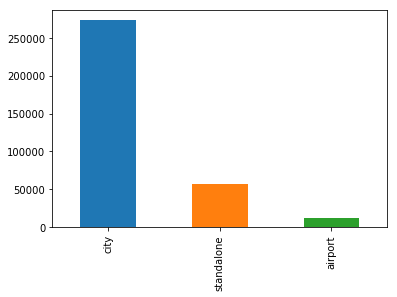

In [205]:
combine = geolocations(combine)

## Precipitation data

In [206]:
# Import precipitation data
prec = pd.read_csv("raindata/precipitation.csv")
prec.date = pd.to_datetime(prec.date, dayfirst=True)
prec.head()

,date,precipitation,new_snow,snow_depth
0,2012-09-01,0.0,0.0,0.0
1,2012-09-02,0.0,0.0,0.0
2,2012-09-03,0.0,0.0,0.0
3,2012-09-04,0.0,0.0,0.0
4,2012-09-05,0.0,0.0,0.0


In [207]:
# Add precipitation data to dataframes
for df in combine:
    df["precipitation"] = np.zeros(df.start_lng.shape)

    for d in prec.date.dt.date:
        df.loc[df.date == d, 'precipitation'] = prec.loc[prec.date.dt.date == d, 'precipitation'].values
    
    df.drop("date", axis=1, inplace=True)

## Mark outliers

In [208]:
# Mark routing errors and short trips
for df in combine:
    df["routing_error"] = np.zeros(df.index.shape)
    df["short_trip"] = np.zeros(df.index.shape)
        
    df.loc[(df.gmaps_dist > 500) & (df.manhattan < 50), "routing_error"] = 1
    df.loc[(df.gmaps_dist < 500) & (df.manhattan < 50), "short_trip"] = 1

## Final dataframes

In [209]:
train_df.head()

,start_lng,start_lat,end_lng,end_lat,duration,manhattan,euclidean,gmaps_dist,gmaps_duration,weekday,hour,holiday,airport,citycenter,standalone,precipitation,routing_error,short_trip
row_id,,,,,,,,,,,,,,,,,,
0,-73.783279,40.644718,-73.963799,40.681320,1815.0,24169.910480,15778.616804,18754.0,2236.0,5,0,0.0,0.0,1.0,1.0,0.07,0.0,0.0
1,-122.422385,37.789408,-122.419890,37.766692,300.0,2806.475682,2538.244354,2847.0,522.0,5,1,0.0,0.0,1.0,1.0,0.00,0.0,0.0
2,-73.885292,40.773060,-74.000076,40.761360,2620.0,14080.134473,9764.679964,14743.0,1916.0,7,20,0.0,0.0,1.0,1.0,0.00,0.0,0.0
3,-122.401603,37.788975,-122.410958,37.796447,360.0,1873.173072,1170.082524,1724.0,512.0,1,23,0.0,0.0,1.0,0.0,0.00,0.0,0.0
4,-74.008728,40.714317,-74.006432,40.731720,582.0,2192.882649,1946.952973,2394.0,611.0,3,12,0.0,0.0,1.0,0.0,0.00,0.0,0.0


In [210]:
test_df.head()

,start_lng,start_lat,end_lng,end_lat,manhattan,euclidean,gmaps_dist,gmaps_duration,weekday,hour,holiday,airport,citycenter,standalone,precipitation,routing_error,short_trip
row_id,,,,,,,,,,,,,,,,,
0,-74.001488,40.726170,-73.962097,40.764500,8651.862144,5407.668349,8956.0,1417.0,6,23,0.0,0.0,1.0,0.0,1.12,0.0,0.0
1,-122.454077,37.774170,-122.428070,37.777023,3212.680504,2310.256486,2496.0,543.0,1,1,0.0,0.0,0.0,1.0,0.00,0.0,0.0
2,-73.976753,40.751575,-73.789917,40.646965,32443.620314,19602.182904,26975.0,1693.0,6,11,0.0,0.0,1.0,0.0,0.00,0.0,0.0
3,-122.405967,37.778165,-122.430198,37.759545,4770.151500,2973.693913,4504.0,689.0,1,5,0.0,0.0,1.0,1.0,0.00,0.0,0.0
4,-73.988197,40.750187,-73.872711,40.774292,15539.199039,10100.308894,14538.0,1264.0,4,9,0.0,0.0,1.0,1.0,0.01,0.0,0.0


In [211]:
# Show correlation table
def correlation_table(train_df):
    colormap = plt.cm.viridis
    plt.figure(figsize=(10,10))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sb.heatmap(train_df.corr().round(2)\
                ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
                linecolor='white', annot=True);

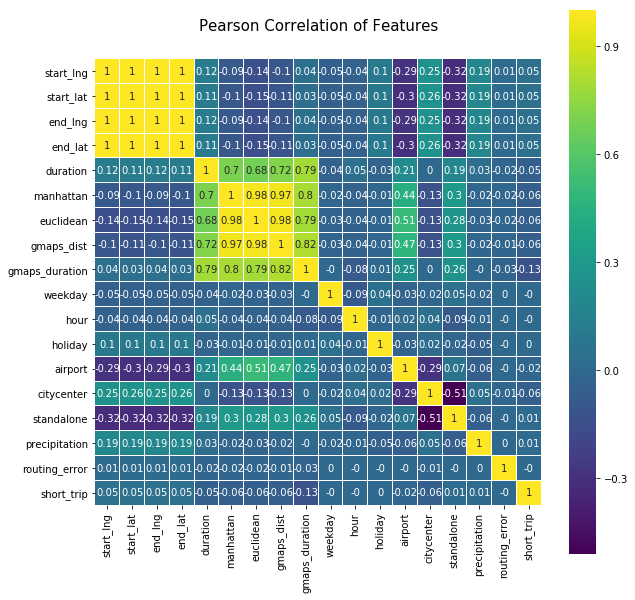

In [212]:
correlation_table(train_df)

# Step 3: Prediction Model

## Define functions

In [213]:
# Plot feature importances
def plot_model_var_imp(model, X):
    imp = pd.DataFrame(model.feature_importances_,
                       columns = ['Importance'],
                       index = X.columns).sort_values(['Importance'], ascending=True)
    imp.plot(kind = 'barh')
    plt.show()

In [214]:
# Normalize data - not used for XGBoost and Random Forest
def normalizer(X):
    
    features = []
    
    coords = X[["start_lng", "start_lat", "end_lng", "end_lat"]]
    coordsnorm = pd.DataFrame(MinMaxScaler(feature_range=(-1,1)).fit_transform(coords), index=coords.index, columns=coords.columns)
    features.append(coordsnorm)

    dist = X[["manhattan", "euclidean", "gmaps_dist", "gmaps_duration"]]
    distnorm = pd.DataFrame(MinMaxScaler(feature_range=(0,10)).fit_transform(dist), index=dist.index, columns=dist.columns)
    features.append(distnorm)

    precipitation = X[["precipitation"]]
    precnorm = pd.DataFrame(MinMaxScaler(feature_range=(0,1)).fit_transform(precipitation), index=precipitation.index, columns=precipitation.columns)
    features.append(precnorm)
    
    times = X[["weekday", "hour"]]
    timesnorm = pd.DataFrame(MinMaxScaler(feature_range=(0,5)).fit_transform(times), index=times.index, columns=times.columns)
    features.append(timesnorm)
    
    flags = X[["holiday", "airport", "citycenter", "standalone", "routing_error", "short_trip"]]
    features.append(flags)

    Xnorm = pd.concat(features, axis=1)
    
    return Xnorm

In [233]:
# Fit model (only XGBoost here)
def regression(train_df, LINREG=False, RIDGE=False, LASSO=False, SVMR=False, XGB=True, RF=False, NN=False):
    X = train_df.drop("duration", axis=1)
    Y = train_df.duration
    Xn = normalizer(X)
    
    np.random.seed(1) # set random seed for reproducibility
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
    Xn_train, Xn_val, Yn_train, Yn_val = train_test_split(Xn, Y, test_size=0.2)
    
    # Linear Regression
    if LINREG:
        st = time.time()
        lin_reg = LinearRegression(normalize=True)
        lin_reg.fit(Xn_train, Yn_train)
        pred_lr = lin_reg.predict(Xn_val)

        print('Linear Regression RMSE with {0} training data points:'.format(len(Xn_train)),
              str(np.sqrt(mean_squared_error(pred_lr, Yn_val))))
        print('Linear Regression CPU Time:', time.time() - st, 'seconds\n')
    else:
        lin_reg = None
    
    # Ridge Regression
    if RIDGE:
        st = time.time()
        ridge = Ridge(alpha=0.5)
        ridge.fit(Xn_train, Yn_train)
        pred_ridge = ridge.predict(Xn_val)

        print('Ridge Regression RMSE with {0} training data points:'.format(len(Xn_train)),
              str(np.sqrt(mean_squared_error(pred_ridge, Yn_val))))
        print('Ridge Regression CPU Time:', time.time() - st, 'seconds\n')
    else:
        ridge = None
        
    # Lasso Regression
    if LASSO:
        st = time.time()
        lasso = Lasso(alpha=0.1, max_iter=5000)
        lasso.fit(Xn_train, Yn_train)
        pred_lasso = lasso.predict(Xn_val)

        print('Lasso Regression RMSE with {0} training data points:'.format(len(Xn_train)),
              str(np.sqrt(mean_squared_error(pred_lasso, Yn_val))))
        print('Lasso Regression CPU Time:', time.time() - st, 'seconds\n')
    else:
        lasso = None
    
    # Support Vector Machines Regressor (non-linear kernel)
    if SVMR:
        st = time.time()
        svr = SVR()
        svr.fit(X_train, Y_train)
        pred_svr = svr.predict(X_val)

        print('Support Vector Regressor RMSE with {0} training data points:'.format(len(X_train)),
              str(np.sqrt(mean_squared_error(pred_svr, Y_val))))
        print('Support Vector Regressor CPU Time:', time.time() - st, 'seconds\n')
    else:
        svr = None
    
    # XGBoost
    if XGB:
        st = time.time()
        xgb = XGBRegressor(max_depth=9, learning_rate=0.045, n_estimators=500, reg_lambda=0.5)
        xgb.fit(X_train, Y_train)
        pred_xgb = xgb.predict(X_val)

        print('XGBoost RMSE with {0} training data points:'.format(len(X_train)),
              str(np.sqrt(mean_squared_error(pred_xgb, Y_val))))
        print('XGBoost CPU Time:', time.time() - st, 'seconds\n')
        plot_model_var_imp(xgb, X_train)
    else:
        xgb = None
    
    # Random Forest
    if RF:
        st = time.time()
        random_forest = RandomForestRegressor(n_estimators=500)
        random_forest.fit(X_train, Y_train)
        pred_rf = random_forest.predict(X_val)

        print('Random Forest RMSE with {0} training data points:'.format(len(X_train)),
              str(np.sqrt(mean_squared_error(pred_rf, Y_val))))
        print('Random Forest CPU Time:', time.time() - st, 'seconds\n')
        plot_model_var_imp(random_forest, X_train)
    else:
        random_forest = None
    
    # Neural Network
    if NN:
        st = time.time()
        NN_model = Sequential()
        NN_model.add(Dense(20, kernel_initializer='normal', input_dim=Xn_train.shape[1], activation='relu'))
        NN_model.add(Dense(150, activation='relu', activity_regularizer=l2(0.2)))
        NN_model.add(Dense(60, activation='relu', activity_regularizer=l2(0.2)))
        NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))
        NN_model.compile(loss='mse', optimizer='adam')
        history = NN_model.fit(Xn_train, Yn_train, epochs=150, batch_size=50, verbose=2, validation_split=0.2)

        plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

        pred_nn = NN_model.predict(Xn_val)
        print('Neural Network RMSE with {0} training data points:'.format(len(Xn_train)),
              str(np.sqrt(mean_squared_error(pred_nn, Yn_val))))
        print('Neural Network CPU Time:', time.time() - st, 'seconds\n')
    else:
        NN_model = None
    
    models = {"Linear Regression": lin_reg,
              "Ridge Regression": ridge,
              "Lasso Regression": lasso,
              "SVR": svr,
              "Random Forest": random_forest,
              "XGBoost": xgb,
              "Neural Network": NN_model}

    return models

## Fit model

Linear Regression RMSE with 112764 training data points: 342.467268018
Linear Regression CPU Time: 0.254108190536499 seconds

XGBoost RMSE with 112764 training data points: 296.928056204
XGBoost CPU Time: 130.43942379951477 seconds



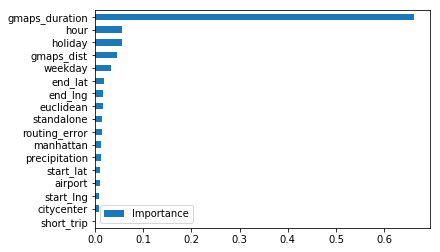

Random Forest RMSE with 112764 training data points: 302.67089157
Random Forest CPU Time: 678.2814381122589 seconds



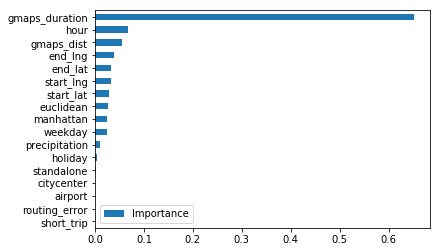

NameError: name 'l2' is not defined

In [234]:
models = regression(train_df)

In [237]:
# Predict durations
xgb = models["XGBoost"]
test_pred = xgb.predict(test_df)

## Compare prediction with training data

In [225]:
# Comparing histograms of predictions
def compare_predictions(pred_1, pred_2):
    bins = np.histogram(np.hstack((pred_1, pred_2)), bins=100)[1] #get the bin edges
    plt.hist(pred_1, bins=bins, alpha=1)
    plt.hist(pred_2, bins=bins, alpha=0.7)
    plt.title("Prediction 1 vs Prediction 2")
    plt.xlabel("Duration [s]")
    plt.ylabel("Number of instances")
    plt.legend(["Prediction 1", "Prediction 2"])
    plt.show()

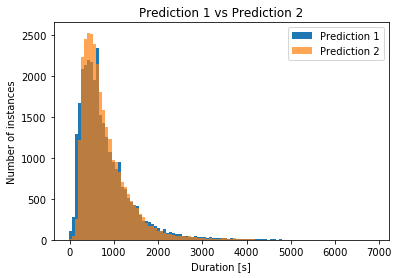

In [226]:
compare_predictions(train_df.sample(len(test_df)).duration.values, test_pred)

# Step 4: Export as .csv-file

In [229]:
def to_submission(prediction):
    date_string = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    file_string = "output/test_prediction_" + date_string + ".csv"
    
    try:
        df = pd.DataFrame(prediction, columns=["duration"])
    except:
        df = pd.DataFrame(prediction.flatten(), columns=["duration"])
        
    df.index.name = "row_id"
    df.to_csv(file_string)

In [230]:
to_submission(test_pred)

# Appendix: XGBoost parameter tuning

This section shows how hyperparameter tuning would work for the XGBoost algorithm, searching for the optimal value of ```max_depth``` and ```learning_rate```.

In [180]:
# Prepare training data
X = train_df.drop("duration", axis=1)
Y = train_df.duration
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

In [185]:
# XGBoost hyperparameter tuning
max_depths = [7, 8, 9, 10, 11]
learning_rates = [0.04, 0.042, 0.044, 0.046, 0.048, 0.05]
optimum = np.ones((3,3)) * float('inf')

for max_depth in tqdm(max_depths):
    for learning_rate in tqdm(learning_rates):
        xgb = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=500, reg_lambda=0.5)
        print("Now training:\tmax_depth = {0}\tlearning_rate = {1}".format(max_depth, learning_rate))
        xgb.fit(X_train, Y_train)
        pred_xgb = xgb.predict(X_val)
        error = np.sqrt(mean_squared_error(pred_xgb, Y_val))
        print("RMSE: {0}".format(error), "\n")
        if error < optimum[0,0]:
            optimum[2,:], optimum[1,:] = optimum[1,:], optimum[0,:]
            optimum[0,:] = np.array([error, max_depth, learning_rate])
        elif error < optimum[1,0]:
            optimum[2,:] = optimum[1,:]
            optimum[1,:] = np.array([error, max_depth, learning_rate])
        elif error < optimum[2,0]:
            optimum[2,:] = np.array([error, max_depth, learning_rate])





  0%|          | 0/5 [00:00<?, ?it/s]




  0%|          | 0/6 [00:00<?, ?it/s]

Now training:	max_depth = 7	learning_rate = 0.04







 17%|█▋        | 1/6 [01:24<07:01, 84.30s/it]

RMSE: 329.93506048561176 

Now training:	max_depth = 7	learning_rate = 0.042







 33%|███▎      | 2/6 [02:49<05:37, 84.44s/it]

RMSE: 330.2929963034172 

Now training:	max_depth = 7	learning_rate = 0.044







 50%|█████     | 3/6 [04:12<04:12, 84.19s/it]

RMSE: 330.4512120600274 

Now training:	max_depth = 7	learning_rate = 0.046







 67%|██████▋   | 4/6 [05:36<02:48, 84.05s/it]

RMSE: 330.1820328639759 

Now training:	max_depth = 7	learning_rate = 0.048







 83%|████████▎ | 5/6 [07:13<01:27, 87.99s/it]

RMSE: 330.17991222326424 

Now training:	max_depth = 7	learning_rate = 0.05







100%|██████████| 6/6 [08:42<00:00, 88.24s/it]



 20%|██        | 1/5 [08:42<34:49, 522.40s/it]




  0%|          | 0/6 [00:00<?, ?it/s]

RMSE: 329.34291666627536 

Now training:	max_depth = 8	learning_rate = 0.04







 17%|█▋        | 1/6 [01:50<09:10, 110.14s/it]

RMSE: 330.4505976833322 

Now training:	max_depth = 8	learning_rate = 0.042







 33%|███▎      | 2/6 [03:38<07:18, 109.67s/it]

RMSE: 329.77440350010954 

Now training:	max_depth = 8	learning_rate = 0.044







 50%|█████     | 3/6 [05:25<05:26, 108.90s/it]

RMSE: 329.55107844943814 

Now training:	max_depth = 8	learning_rate = 0.046







 67%|██████▋   | 4/6 [07:16<03:39, 109.52s/it]

RMSE: 330.16935013287434 

Now training:	max_depth = 8	learning_rate = 0.048







 83%|████████▎ | 5/6 [09:08<01:50, 110.08s/it]

RMSE: 329.8451651945308 

Now training:	max_depth = 8	learning_rate = 0.05







100%|██████████| 6/6 [10:56<00:00, 109.61s/it]



 40%|████      | 2/5 [19:39<28:08, 562.69s/it]




  0%|          | 0/6 [00:00<?, ?it/s]

RMSE: 330.1036654677163 

Now training:	max_depth = 9	learning_rate = 0.04







 17%|█▋        | 1/6 [01:59<09:59, 119.96s/it]

RMSE: 328.7138433417013 

Now training:	max_depth = 9	learning_rate = 0.042







 33%|███▎      | 2/6 [03:54<07:53, 118.30s/it]

RMSE: 330.03747006902 

Now training:	max_depth = 9	learning_rate = 0.044







 50%|█████     | 3/6 [05:47<05:50, 116.79s/it]

RMSE: 328.84218146659987 

Now training:	max_depth = 9	learning_rate = 0.046







 67%|██████▋   | 4/6 [07:42<03:52, 116.25s/it]

RMSE: 330.19293251198394 

Now training:	max_depth = 9	learning_rate = 0.048







 83%|████████▎ | 5/6 [09:37<01:55, 115.78s/it]

RMSE: 329.60163682438633 

Now training:	max_depth = 9	learning_rate = 0.05







100%|██████████| 6/6 [11:39<00:00, 117.57s/it]



 60%|██████    | 3/5 [31:18<20:07, 603.61s/it]




  0%|          | 0/6 [00:00<?, ?it/s]

RMSE: 329.3672578492086 

Now training:	max_depth = 10	learning_rate = 0.04







 17%|█▋        | 1/6 [02:07<10:39, 127.92s/it]

RMSE: 330.0121941362103 

Now training:	max_depth = 10	learning_rate = 0.042







 33%|███▎      | 2/6 [04:27<08:45, 131.28s/it]

RMSE: 330.4558240915728 

Now training:	max_depth = 10	learning_rate = 0.044







 50%|█████     | 3/6 [06:48<06:42, 134.32s/it]

RMSE: 330.22411696002115 

Now training:	max_depth = 10	learning_rate = 0.046







 67%|██████▋   | 4/6 [09:10<04:33, 136.72s/it]

RMSE: 330.29797209286266 

Now training:	max_depth = 10	learning_rate = 0.048







 83%|████████▎ | 5/6 [11:15<02:13, 133.18s/it]

RMSE: 330.53889183785674 

Now training:	max_depth = 10	learning_rate = 0.05







100%|██████████| 6/6 [13:20<00:00, 130.58s/it]



 80%|████████  | 4/5 [44:38<11:02, 662.60s/it]




  0%|          | 0/6 [00:00<?, ?it/s]

RMSE: 330.6262623648578 

Now training:	max_depth = 11	learning_rate = 0.04







 17%|█▋        | 1/6 [02:21<11:45, 141.06s/it]

RMSE: 331.1504239555211 

Now training:	max_depth = 11	learning_rate = 0.042







 33%|███▎      | 2/6 [04:49<09:33, 143.26s/it]

RMSE: 330.74648778089124 

Now training:	max_depth = 11	learning_rate = 0.044







 50%|█████     | 3/6 [07:08<07:06, 142.11s/it]

RMSE: 330.84958716509715 

Now training:	max_depth = 11	learning_rate = 0.046







 67%|██████▋   | 4/6 [09:26<04:41, 140.82s/it]

RMSE: 330.7312181759748 

Now training:	max_depth = 11	learning_rate = 0.048







 83%|████████▎ | 5/6 [11:42<02:19, 139.34s/it]

RMSE: 330.54501972084296 

Now training:	max_depth = 11	learning_rate = 0.05







100%|██████████| 6/6 [13:59<00:00, 138.68s/it]



100%|██████████| 5/5 [58:38<00:00, 715.73s/it]

RMSE: 331.6242922109879 



Optimal hyperparameters: [[  3.28713843e+02   9.00000000e+00   4.00000000e-02]
 [  3.28842181e+02   9.00000000e+00   4.40000000e-02]
 [  3.29342917e+02   7.00000000e+00   5.00000000e-02]]
Optimal XGBoost RMSE with 112783 training data points: 328.713843342


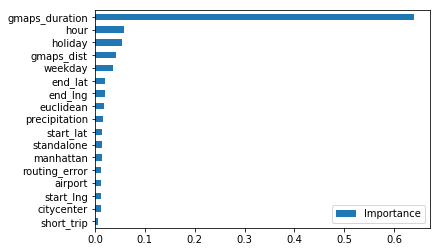

In [187]:
# Display optimal hyperparameters and fit into model
print('Optimal hyperparameters:', optimum)

xgb = XGBRegressor(max_depth=int(optimum[0][1]), learning_rate=optimum[0][2], n_estimators=500, reg_lambda=0.5)
xgb.fit(X_train, Y_train)
pred_xgb = xgb.predict(X_val)
                
print('Optimal XGBoost RMSE with {0} training data points:'.format(len(X_train)),
      str(np.sqrt(mean_squared_error(pred_xgb, Y_val))))

plot_model_var_imp(xgb, X_train)